In [3]:
import pandas as pd
import numpy as np

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#from dask_searchcv import GridSearchCV
#from dask_searchcv import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

In [4]:


df = pd.read_csv('./data/clean.csv')
df = df.dropna()


# reduced features
'''
[(0.0966, 'lender'), (0.0963, 'applicant_income'), (0.0949, 'loan_amount'), (0.0848, 'minority_population_pct'), (0.0825, 'ffiecmedian_family_income'), (0.0777, 'population'), (0.0766, 'number_of_owner-occupied_units'), (0.0762, 'number_of_1_to_4_family_units'), (0.0572, 'county_code'),
(0.0544, 'loan_purpose'), (0.0489, 'msa_md'), (0.0445, 'state_code'), (0.0383, 'tract_to_msa_md_income_pct'), (0.0148, 'applicant_race'), (0.0133, 'loan_type'), (0.0126, 'property_type'), (0.0106, 'co_applicant'), (0.0105, 'applicant_ethnicity'), (0.0094, 'preapproval')]
'''
reduced_feature_df = df[['accepted','lender','applicant_income', 'loan_amount', 'minority_population_pct','ffiecmedian_family_income', 'population', 'number_of_owner-occupied_units','number_of_1_to_4_family_units', 'loan_purpose','co_applicant', 'loan_type'  ]]

reduced_feature_df.head(5)

,accepted,lender,applicant_income,loan_amount,minority_population_pct,ffiecmedian_family_income,population,number_of_owner-occupied_units,number_of_1_to_4_family_units,loan_purpose,co_applicant,loan_type
0,1,4536,0.002269,0.000684,44.230,0.397896,0.166896,0.081214,0.193878,1,0,3
1,0,2458,0.005524,0.001755,15.905,0.344194,0.155327,0.184556,0.154676,3,0,1
2,1,5710,0.006510,0.001606,61.270,0.464298,0.163957,0.086232,0.076861,3,0,2
3,1,5888,0.010258,0.001527,6.246,0.564121,0.179408,0.230524,0.168698,1,1,1
4,1,289,0.006905,0.003014,100.000,0.421054,0.181161,0.166534,0.135516,1,0,1


In [5]:
# split up the data into labels and features
labels = reduced_feature_df['accepted']
features = reduced_feature_df.drop(columns=['accepted'])

# split test / train data
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import datetime

# first pass - standard 50/50 split
train, test, train_labels, test_labels = train_test_split(features,
                                                          labels,
                                                          test_size=0.4,
                                                          random_state=123)

In [6]:


# Initialize our classifier
gnb = GaussianNB()

# Train our classifier
model = gnb.fit(train, train_labels)
preds = gnb.predict(test)

# Evaluate accuracy
print('accuracy of model is:',accuracy_score(test_labels, preds))

def export_submission(predictions, df, export_label_column):
    df = pd.DataFrame({export_label_column: predictions})
    df['row_id'] = df.index

    df_export = pd.DataFrame({'row_id':df['row_id'], export_label_column:df[export_label_column]})
    
    currentDT = datetime.datetime.now()
    #export_path = str(currentDT.strftime("%Y-%m-%d %H:%M:%S")) + ".csv"
    #export_path = str(export_path.replace(" ", "_"))
    export_path = "output.csv"
    df_export.to_csv(export_path, index=False)
    print('exporting results to: ', export_path, '# records ', len(df_export))
    
export_submission(preds, df, 'accepted')

accuracy of model is: 0.6095309808216678
exporting results to:  output.csv # records  175302


In [7]:
from sklearn.ensemble import RandomForestClassifier 
import matplotlib.pyplot as plt
import numpy as np

# create a new classifiser
rfc = RandomForestClassifier()
# Train the model
model2 = rfc.fit(train, train_labels)
preds2 = rfc.predict(test)
col_names = reduced_feature_df.columns.values

print('accuracy of model2 is:',accuracy_score(test_labels, preds2))

print("Features sorted by their score:")
zipped_objs = zip(map(lambda x: round(x, 4), rfc.feature_importances_), col_names)
print( sorted(zipped_objs, reverse=True) )


C:\Users\BenMcC\AppData\Local\conda\conda\envs\mortgage-classifier-capstone\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy of model2 is: 0.6353721007176187
Features sorted by their score:
[(0.1266, 'accepted'), (0.1245, 'applicant_income'), (0.1219, 'lender'), (0.1167, 'loan_amount'), (0.1148, 'minority_population_pct'), (0.1052, 'ffiecmedian_family_income'), (0.1049, 'number_of_owner-occupied_units'), (0.1041, 'population'), (0.0565, 'number_of_1_to_4_family_units'), (0.0147, 'co_applicant'), (0.0102, 'loan_purpose')]


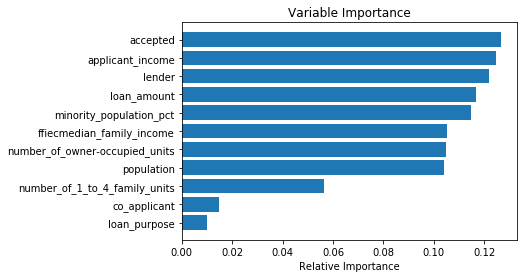

In [8]:
# Isolate feature importances 
importance = rfc.feature_importances_

# Sort the feature importances 
sorted_importances = np.argsort(importance)

# Insert padding
padding = np.arange(len(col_names)-1) + 0.5

# Plot the data
plt.barh(padding, importance[sorted_importances], align='center')

# Customize the plot
plt.yticks(padding, col_names[sorted_importances])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")

# Show the plot
plt.show()

In [9]:
# export the model for use in other notebooks
import pickle

filename = 'RandomForestClassifier_v1.sav'
pickle.dump(model, open(filename, 'wb'))

In [10]:
'''
# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)

start = time()
#model2 = rfc.fit(train, train_labels)
random_search.fit(train, train_labels)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)
start = time()
grid_search.fit(train, train_labels)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)
'''

'\n# build a classifier\nclf = RandomForestClassifier(n_estimators=20)\n\n\n# Utility function to report best scores\ndef report(results, n_top=3):\n    for i in range(1, n_top + 1):\n        candidates = np.flatnonzero(results[\'rank_test_score\'] == i)\n        for candidate in candidates:\n            print("Model with rank: {0}".format(i))\n            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(\n                  results[\'mean_test_score\'][candidate],\n                  results[\'std_test_score\'][candidate]))\n            print("Parameters: {0}".format(results[\'params\'][candidate]))\n            print("")\n\n\n# specify parameters and distributions to sample from\nparam_dist = {"max_depth": [3, None],\n              "max_features": sp_randint(1, 11),\n              "min_samples_split": sp_randint(2, 11),\n              "bootstrap": [True, False],\n              "criterion": ["gini", "entropy"]}\n\n# run randomized search\nn_iter_search = 20\nrandom_search = 